In [1]:
import numpy as np
import os
import pandas as pd
import plotly.express as px
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.cluster import SpectralClustering

from regimetry.config import Config
from regimetry.logger_manager import LoggerManager
from regimetry.utils.file_utils import load_array


In [2]:

logging = LoggerManager.get_logger("positional_encoding.ipynb")

In [3]:
cfg = Config()
print("PROJECT ROOT:", cfg.PROJECT_ROOT)
print("BASE DIR:", cfg.BASE_DIR)
print("RAW DATA:", cfg.RAW_DATA_DIR)
print("PROCESSED DATA:", cfg.PROCESSED_DATA_DIR)
print("EMBEDDINGS DATA:", cfg.EMBEDDINGS_DIR)

PROJECT ROOT: /Users/kenneth/Public/projects/python/ai/regimetry
BASE DIR: /Users/kenneth/Public/projects/python/ai/regimetry/artifacts
RAW DATA: /Users/kenneth/Public/projects/python/ai/regimetry/artifacts/data/raw
PROCESSED DATA: /Users/kenneth/Public/projects/python/ai/regimetry/artifacts/data/processed
EMBEDDINGS DATA: /Users/kenneth/Public/projects/python/ai/regimetry/artifacts/embeddings


In [4]:
embedding_path = os.path.join(cfg.EMBEDDINGS_DIR, "EUR_USD_embeddings.npy")  # or your chosen filename
embeddings = load_array(embedding_path)

print("Loaded embeddings shape:", embeddings.shape)


[ 2025-05-12 08:37:28 ] INFO [../../src/regimetry/utils/file_utils.py:168] - Array loaded successfully from /Users/kenneth/Public/projects/python/ai/regimetry/artifacts/embeddings/EUR_USD_embeddings.npy
Loaded embeddings shape: (1840, 80)


/Users/kenneth/Public/projects/python/ai/regimetry/.venv/lib/python3.12/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


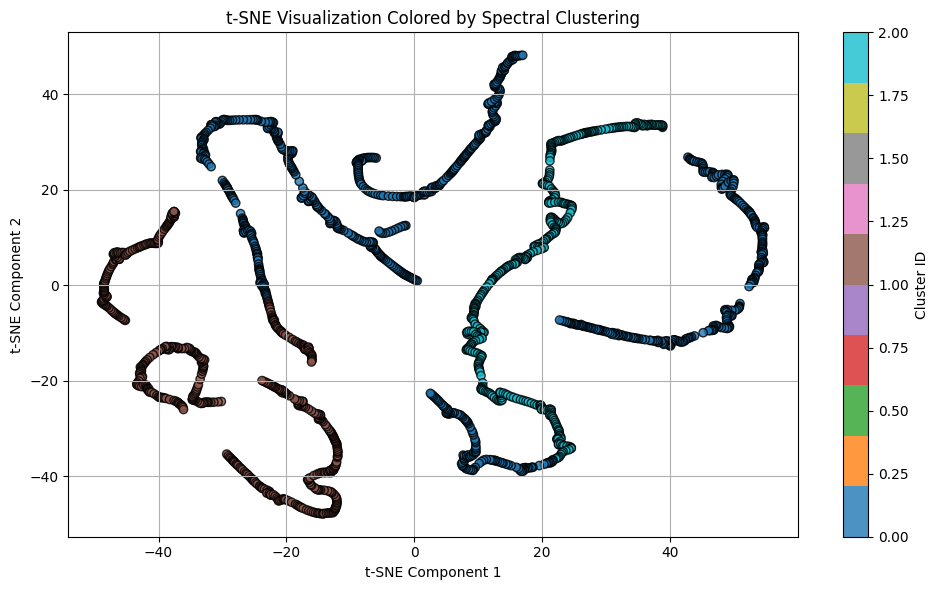

Cluster Summary: {np.int32(0): np.int64(934), np.int32(1): np.int64(524), np.int32(2): np.int64(382)}


In [5]:
# Step 1: Run model to get embeddings
# embeddings = model.predict(X_pe, batch_size=64)

# Step 2: Scale embeddings
scaler = StandardScaler()
embeddings_scaled = scaler.fit_transform(embeddings)

# ✅ Step 3: Spectral Clustering on real embedding space (not t-SNE)
n_clusters = 3
spectral = SpectralClustering(
    n_clusters=n_clusters,
    #affinity='rbf',  # or 'nearest_neighbors'
    affinity='nearest_neighbors',
    assign_labels='kmeans',
    random_state=42,
)
cluster_labels = spectral.fit_predict(embeddings_scaled)

# ✅ Step 4: t-SNE for visualization only
tsne = TSNE(n_components=2, perplexity=30, random_state=42, n_iter=1000)
embeddings_tsne = tsne.fit_transform(embeddings_scaled)

# ✅ Step 5: Use cluster_labels from SpectralClustering for coloring
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
scatter = plt.scatter( 
    embeddings_tsne[:, 0],
    embeddings_tsne[:, 1],
    c=cluster_labels,
    cmap='tab10',
    edgecolors='k',
    alpha=0.8
)
#scatter = plt.scatter(embeddings_tsne[:, 0], embeddings_tsne[:, 1], c=np.arange(len(embeddings_tsne)), cmap='viridis')

plt.title("t-SNE Visualization Colored by Spectral Clustering")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.colorbar(scatter, label="Cluster ID")
#plt.colorbar(scatter, label="sequence index")

plt.grid(True)
plt.tight_layout()
plt.show()

# Step 6: Print cluster summary
unique, counts = np.unique(cluster_labels, return_counts=True)
cluster_summary = dict(zip(unique, counts))
print("Cluster Summary:", cluster_summary)

/Users/kenneth/Public/projects/python/ai/regimetry/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/kenneth/Public/projects/python/ai/regimetry/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/kenneth/Public/projects/python/ai/regimetry/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


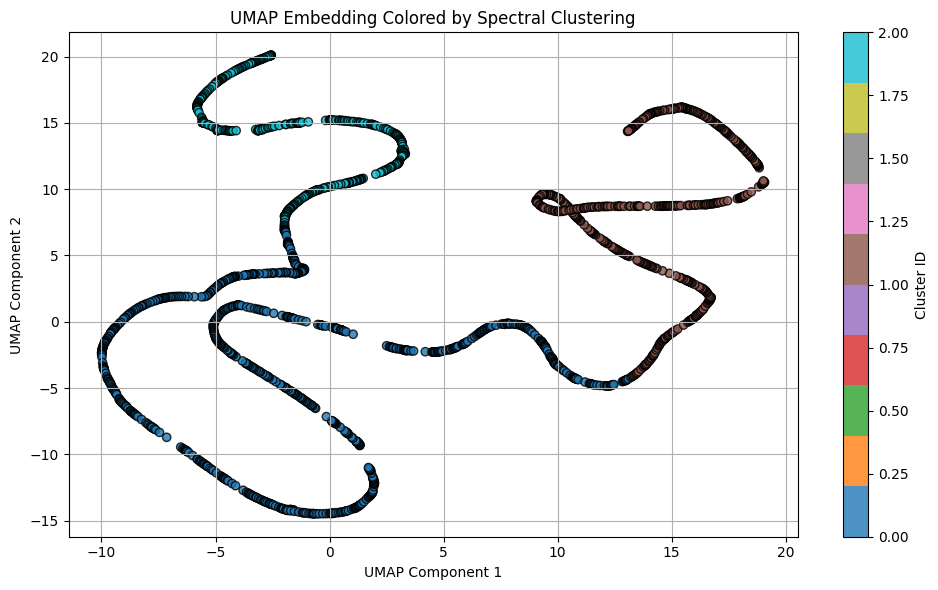

In [6]:
from umap import UMAP

umap = UMAP(n_components=2, random_state=42)
embeddings_umap = umap.fit_transform(embeddings_scaled)

# Plot with cluster_labels from SpectralClustering
plt.figure(figsize=(10, 6))
plt.scatter(
    embeddings_umap[:, 0],
    embeddings_umap[:, 1],
    c=cluster_labels,
    cmap='tab10',
    edgecolors='k',
    alpha=0.8
)
plt.title("UMAP Embedding Colored by Spectral Clustering")
plt.xlabel("UMAP Component 1")
plt.ylabel("UMAP Component 2")
plt.colorbar(label="Cluster ID")
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# Parameters
WINDOW_SIZE = 30

processed_file = os.path.join(cfg.PROCESSED_DATA_DIR, "regime_input.csv")
print(processed_file)
# Step 1: Load raw data
df = pd.read_csv(processed_file)

# Step 2: Load or assign your cluster labels (length should match number of embeddings)
# Assuming you already have this array
# cluster_labels = [0, 1, 2, ..., len(df) - window_size + 1]

# Step 3: Create empty column and fill cluster labels aligned to end of each window
df['Cluster_ID'] = np.nan
df.loc[WINDOW_SIZE - 1 : WINDOW_SIZE - 1 + len(cluster_labels), 'Cluster_ID'] = cluster_labels

# Optional: drop rows without cluster assignment (i.e., first `window_size - 1` rows)
df_cleaned = df.dropna(subset=['Cluster_ID']).copy()
df_cleaned['Cluster_ID'] = df_cleaned['Cluster_ID'].astype(int)

/Users/kenneth/Public/projects/python/ai/regimetry/artifacts/data/processed/regime_data.csv


FileNotFoundError: [Errno 2] No such file or directory: '/Users/kenneth/Public/projects/python/ai/regimetry/artifacts/data/processed/regime_data.csv'

In [ ]:
df_cleaned.head


In [ ]:
df_cleaned.columns

In [ ]:
plt.figure(figsize=(14, 4))
plt.plot(df_cleaned['Cluster_ID'].values, label="Regime ID", marker='o')
plt.title("Cluster Regimes Over Time")
plt.xlabel("Time Index")
plt.ylabel("Cluster ID")
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(14, 6))
plt.plot(df_cleaned['Close'].values, label='Close', color='black', alpha=0.7)
plt.scatter(range(len(df_cleaned)), df_cleaned['Close'], c=df_cleaned['Cluster_ID'], cmap='tab10', edgecolors='k')
plt.title("Close Price with Cluster Overlay")
plt.xlabel("Time Index")
plt.ylabel("Price")
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
fig = px.scatter(
    df_cleaned,
    x=df_cleaned.index,  # or 'Date'
    y='Close',
    color='Cluster_ID',
    title="Interactive Clustered Regime Visualization",
    hover_data=['Cluster_ID', 'AHMA', 'LC_Slope', 'ATR'],  # Optional
    color_continuous_scale='Viridis'
)
fig.update_traces(marker=dict(size=6, line=dict(width=0.5, color='black')))
fig.update_layout(height=600)
fig.show()